In [1]:
#XGBoost Model for feature selection

# 1: Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2: Load and filter data
# 2.1 Load data
df = pd.read_sas('C:/Users/khtur/Desktop/Eas/Models/abt_app.sas7bdat', encoding='LATIN2')

#. 2.2 Filter data
df = df[('197501' <= df['period']) & (df['period'] <= '198712') & (df['product'] == 'css') & (df['decision'] == 'A')]

In [3]:
# 3: Prepare features and target (Updated)
# 3.1 Define target variable
target_name = 'default12'

# 3.2 Prepare features
vars = [var for var in list(df) if var[0:3].lower() in ['app', 'act', 'agr', 'ags']]
X = df[vars].copy()  # Create an explicit copy
y = df[target_name]

# 3.3 Remove rows where the target variable is NaN or infinity
mask = ~(y.isna() | y.isin([np.inf, -np.inf]))
X = X[mask]
y = y[mask]

print(f"Removed {len(df) - len(X)} rows with NaN or infinity values in the target variable")

# 3.4 Handle categorical variables
cat_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# 3.5 Handle NaN and infinity values in features
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

Removed 1576 rows with NaN or infinity values in the target variable


In [4]:
# 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# 5: Define helper function
def get_top_features(importance_dict, n=20):
    return sorted(importance_dict, key=importance_dict.get, reverse=True)[:n]

In [6]:
# 6: Train initial model (Updated)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

In [7]:
# 7: Calculate feature importance
# 7.1 Get feature importance
importance_dict = model.get_score(importance_type='gain')

# 7.2 Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print(shap_values)
# 7.3 Combine XGBoost and SHAP importance
shap_importance = np.abs(shap_values).mean(0)
shap_importance_dict = dict(zip(X.columns, shap_importance))

combined_importance = {feature: (importance_dict.get(feature, 0) + shap_importance_dict.get(feature, 0)) / 2 for feature in set(importance_dict) | set(shap_importance_dict)}

[[ 3.6131659e-01 -2.5705174e-01 -2.1780046e-02 ... -1.9417774e-02
   0.0000000e+00  1.4219061e-04]
 [-5.4638451e-01 -6.6013105e-02 -4.6612523e-03 ... -1.9650690e-02
   0.0000000e+00  6.8167578e-03]
 [ 5.3483921e-01 -3.2287765e-01 -5.6245024e-03 ... -1.9168805e-02
   0.0000000e+00 -5.4462228e-02]
 ...
 [ 5.5005664e-01 -1.8184695e-01 -7.9445569e-03 ...  4.7895260e-02
   0.0000000e+00 -7.4877935e-03]
 [-1.6888803e-01 -1.6419406e-01 -1.0734995e-02 ... -1.9435296e-02
   0.0000000e+00  2.8711753e-02]
 [-6.7059982e-01 -1.3204281e-01 -2.0460092e-02 ... -1.4531064e-02
   0.0000000e+00  3.3162292e-03]]


In [8]:
# 8: Select top features
top_features = get_top_features(combined_importance, n=40)

print("Top 20 selected features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

Top 20 selected features:
1. agr3_Mean_CMaxA_Due
2. act_ccss_dueutl
3. agr3_Mean_CMaxC_Due
4. act_ccss_n_loans_act
5. agr3_Max_CMaxA_Due
6. act_ccss_maxdue
7. ags12_Mean_CMaxA_Due
8. ags12_Max_CMaxC_Days
9. ags12_Min_CMaxC_Due
10. act_ccss_n_statC
11. ags12_Mean_CMaxC_Due
12. app_char_job_code
13. act_ccss_cc
14. app_income
15. ags6_Max_CMaxI_Days
16. ags3_Mean_CMaxI_Due
17. act_ccss_n_loan
18. act_ccss_min_seniority
19. agr9_Min_CMaxC_Due
20. agr6_Mean_CMaxA_Due
21. act12_n_arrears
22. act_ccss_min_pninst
23. app_number_of_children
24. act_call_cc
25. agr9_Min_CMaxA_Due
26. act_age
27. agr12_Max_CMaxC_Days
28. act3_n_arrears
29. app_char_marital_status
30. ags12_Max_CMaxA_Due
31. act_cins_n_statC
32. ags9_Min_CMaxC_Due
33. ags6_Max_CMaxA_Days
34. agr6_Mean_CMaxC_Days
35. agr6_Max_CMaxA_Due
36. agr9_Min_CMaxI_Due
37. act_ccss_min_lninst
38. ags3_Max_CMaxC_Days
39. ags12_Mean_CMaxI_Due
40. act_cc


In [9]:
# 9: Train final model with selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
dtest_selected = xgb.DMatrix(X_test_selected, label=y_test)

final_model = xgb.train(params, dtrain_selected, num_boost_round=100, evals=[(dtest_selected, 'eval')], early_stopping_rounds=10, verbose_eval=False)

In [10]:
# 10: Evaluate model
y_pred = final_model.predict(dtest_selected)
auc = roc_auc_score(y_test, y_pred)
print(f"Final model AUC: {auc:.4f}")

Final model AUC: 0.8607


In [11]:
# 11: Save the model
final_model.save_model('xgb_credit_scoring_model.ubj')
print("Model saved as 'xgb_credit_scoring_model.model'")

Model saved as 'xgb_credit_scoring_model.model'


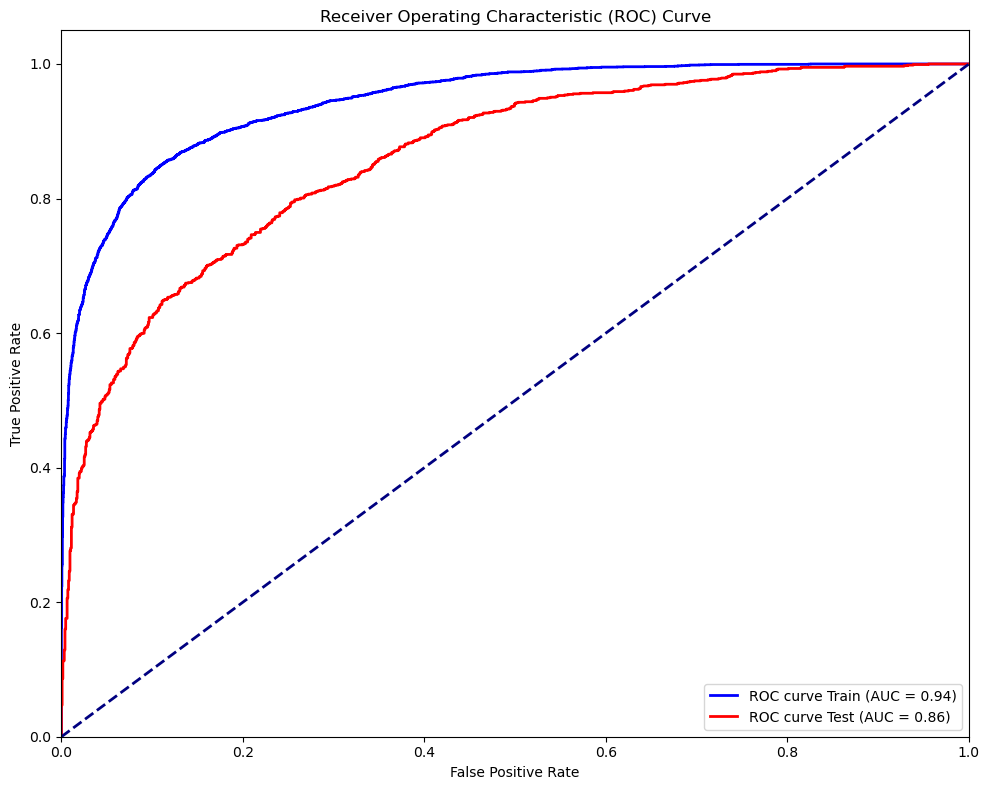

ROC AUC Train: 0.9443
ROC AUC Test: 0.8607
Combined ROC curve plot saved as 'roc_curve_combined.png'
Threshold: 0.1, Specificity: 0.2602, Sensitivity: 0.9849
Threshold: 0.2, Specificity: 0.4662, Sensitivity: 0.9489
Threshold: 0.3, Specificity: 0.6211, Sensitivity: 0.8794
Threshold: 0.4, Specificity: 0.7233, Sensitivity: 0.8082
Threshold: 0.5, Specificity: 0.7948, Sensitivity: 0.7379
Threshold: 0.6, Specificity: 0.8546, Sensitivity: 0.6776
Threshold: 0.7, Specificity: 0.9080, Sensitivity: 0.6047
Threshold: 0.8, Specificity: 0.9513, Sensitivity: 0.5059
Threshold: 0.9, Specificity: 0.9819, Sensitivity: 0.3786


In [12]:
# 12: ROC AUC Visualization for Both Training and Test Sets
from sklearn.metrics import roc_curve, auc

# 12.1 Function to calculate predictions
def get_predictions(model, data):
    dmatrix = xgb.DMatrix(data)
    return model.predict(dmatrix)

# 12.2 Get predictions for both training and test sets
y_pred_train = get_predictions(final_model, X_train_selected)
y_pred_test = get_predictions(final_model, X_test_selected)

# 12.3 Calculate ROC curve and AUC for both sets
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# 12.4 Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC curve Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC AUC Train: {roc_auc_train:.4f}")
print(f"ROC AUC Test: {roc_auc_test:.4f}")
print("Combined ROC curve plot saved as 'roc_curve_combined.png'")

# 12.5 Calculate and print some key points on the ROC curve for the test set
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    tn = sum((y_pred_test < threshold) & (y_test == 0))
    tp = sum((y_pred_test >= threshold) & (y_test == 1))
    fn = sum((y_pred_test < threshold) & (y_test == 1))
    fp = sum((y_pred_test >= threshold) & (y_test == 0))
    
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"Threshold: {threshold:.1f}, Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}")

<Figure size 1000x600 with 0 Axes>

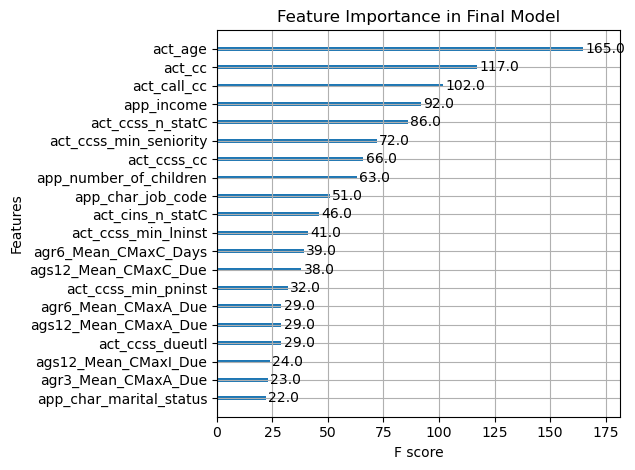

Feature importance plot saved as 'feature_importance.png'


In [13]:
# 13: Create and save feature importance plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, max_num_features=20)
plt.title('Feature Importance in Final Model')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()
print("Feature importance plot saved as 'feature_importance.png'")

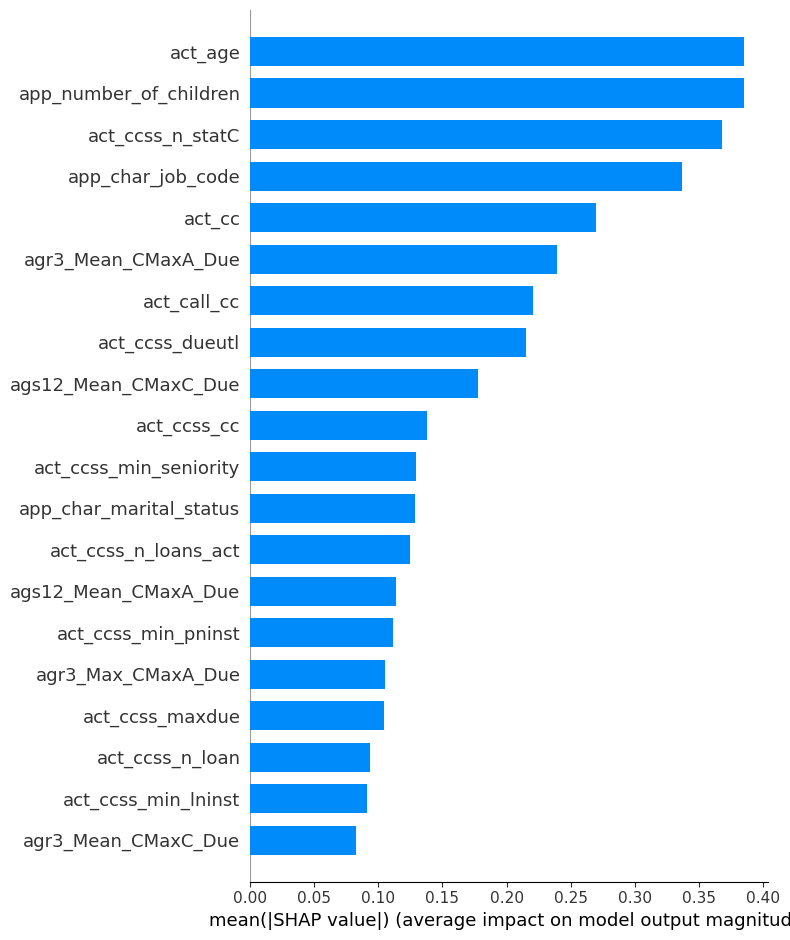

SHAP summary bar plot saved as 'shap_summary_bar.png'
SHAP dependence plot for act_age saved as 'shap_dependence_act_age.png'
SHAP dependence plot for app_number_of_children saved as 'shap_dependence_app_number_of_children.png'
SHAP dependence plot for act_ccss_n_statC saved as 'shap_dependence_act_ccss_n_statC.png'
SHAP dependence plot for app_char_job_code saved as 'shap_dependence_app_char_job_code.png'
SHAP dependence plot for act_cc saved as 'shap_dependence_act_cc.png'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [31]:
# 14.2 Calculate SHAP values for X_test_selected (without DMatrix)
shap_values_final = explainer_final.shap_values(X_test_selected)

# Calculate the mean SHAP values for each feature (absolute values)
mean_shap_values = np.abs(shap_values_final).mean(axis=0)

# Sort features by their mean SHAP values
sorted_features = X_test_selected.columns[np.argsort(mean_shap_values)[::-1]]

# Generate and save SHAP summary bar plot (mean SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_final, X_test_selected, plot_type="bar", max_display=20, show=False)
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')  # Save the plot
plt.show()
print("SHAP summary bar plot saved as 'shap_summary_bar.png'")

# Select top 5 features based on SHAP values
top_features = sorted_features[:5]

# Generate SHAP dependence plot for the most important features
for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values_final, X_test_selected, show=False)  # Add show=False to avoid displaying
    plt.tight_layout()
    plt.savefig(f'shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')  # Save the plot
    plt.close()
    print(f"SHAP dependence plot for {feature} saved as 'shap_dependence_{feature}.png'")


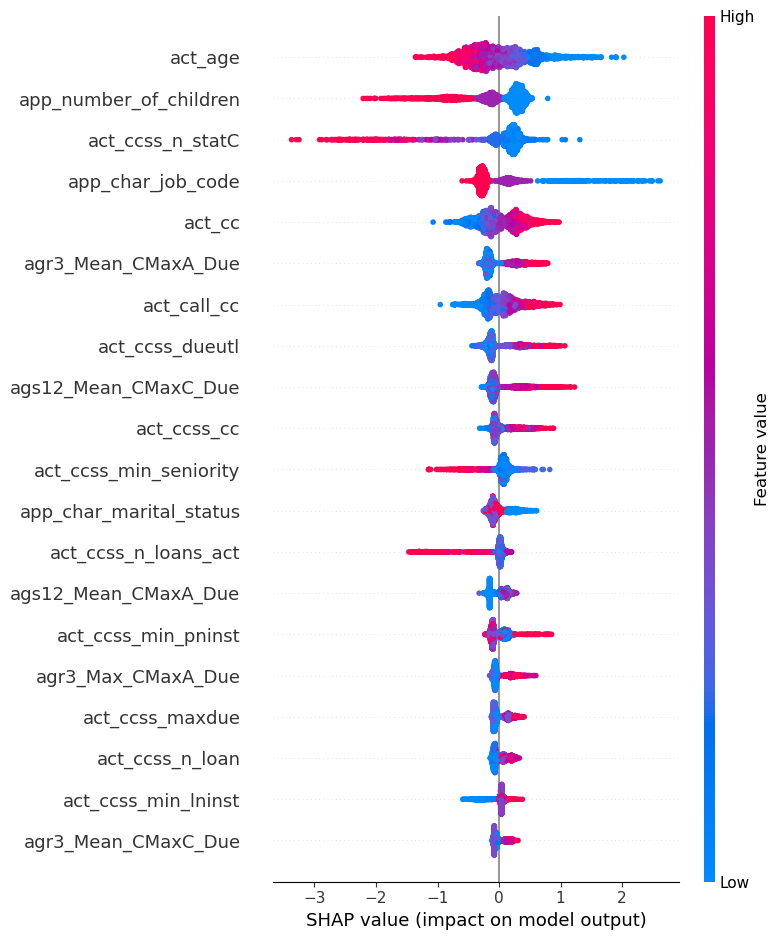

In [30]:
# 14.2 Calculate SHAP values for X_test_selected (without DMatrix)
shap_values_final = explainer_final.shap_values(X_test_selected)

# 14.3 Create and save SHAP summary plot for X_test_selected
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_final, X_test_selected, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()